<a href="https://colab.research.google.com/github/yaniv92648/OpenU_DL/blob/main/OpenU_DL_Maman_13_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

לינק להקלטה

https://drive.google.com/file/d/1oTA8hWF36BOgA6Jiddk2H4QDwRoHHb6z/view?usp=sharing

In [ ]:
import torch
from torch import nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import heapq
from PIL import Image
from time import time
import copy

# GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Question 1

תיקון טעות מההקלטה, בסוף הלולאה היא על הקלט, לא על 

Output

In [ ]:
class ConvPaddingStride(nn.Module):
  
  def __init__(self,
               in_channels=1, 
               out_channels=1, 
               kernel_size=(1,1), 
               stride=1, 
               padding=0):
    super().__init__()
    # out_channels kernels (matrices) with in_channels dimnesions each
    self.kern = torch.rand(out_channels, in_channels, *kernel_size)
    self.out_channels = out_channels
    self.p, self.q = kernel_size
    self.padding = padding
    self.stride = stride

  def forward(self, X):
    # Padding
    X_padded = torch.zeros(X.shape[0], 
                           X.shape[1], 
                           X.shape[2]+2*self.padding, 
                           X.shape[3]+2*self.padding)
    X_padded[:,
             :,
             self.padding:(X_padded.shape[2]-self.padding),
             self.padding:(X_padded.shape[3]-self.padding)] = X
    X = X_padded
    # Convolution
    output = torch.empty(X.size(0), # Batch - Num of samples
                         self.out_channels, # Num of kernels
                         int((X.size(-2)-self.p)/self.stride+1),
                         int((X.size(-1)-self.q)/self.stride+1))
    for i in range(0, X.size(-2), self.stride):
      for j in range(0, X.size(-1), self.stride):
        sub_img = X[:,:,i:(i+self.p),j:(j+self.q)].unsqueeze(1)
        i_s, j_s = i//self.stride, j//self.stride
        output[:,:,i_s,j_s] = (sub_img*self.kern).sum(dim=(2,3,4))
    return output

## Get images from CIFAR10

In [ ]:
batch_size = 4
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, 
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()

Files already downloaded and verified


## Compare Convolution layer of user & CP

In [ ]:
conv2d_cp = nn.Conv2d(in_channels=3,
                      out_channels=1, 
                      kernel_size=(2,2), 
                      stride=1, 
                      padding=1)
conv2d_user = ConvPaddingStride(in_channels=3, 
                                out_channels=1,
                                kernel_size=(2,2), 
                                stride=1, 
                                padding=1)

kernel = nn.Parameter(torch.rand_like(conv2d_user.kern))
conv2d_user.kern, conv2d_cp.weight = kernel, kernel
# conv2d_user doesn't have bias
conv2d_cp.bias = nn.Parameter(torch.zeros_like(conv2d_cp.bias)) 

epsilon = 10**(-5)
((conv2d_user(images) - conv2d_cp(images)) < epsilon).all()

tensor(True)

# Question 2 - Forward Propagation - j can be 1 or 2

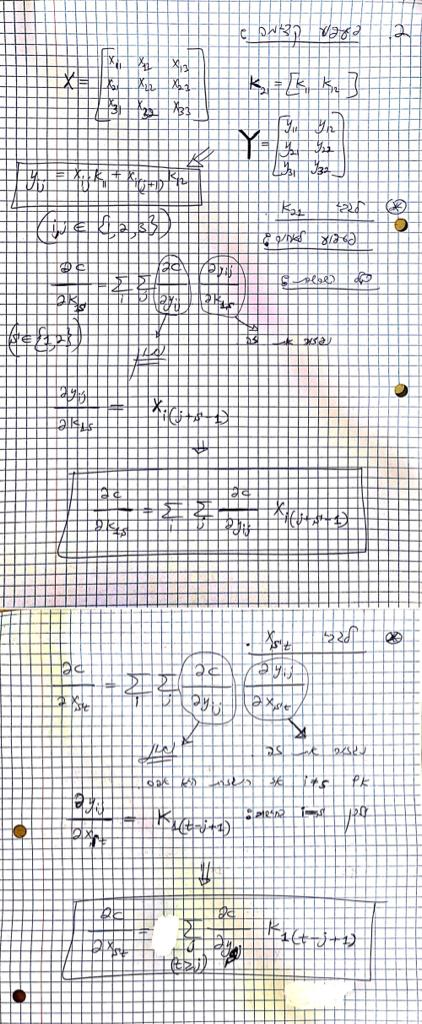

# Question 3 - ג

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

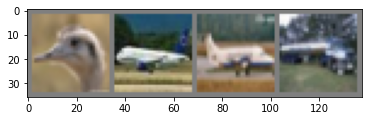

bird           plane          plane          truck


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('          '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# Question 3 - ד + ה + ו + ז

In [ ]:
batch_size = 100

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False)

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': batch_size*len(trainloader), 
                 'val': batch_size*len(testloader)}


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_model(model, criterion, optimizer, num_epochs, check_wrong_preds):
  since = time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  wrong_preds = []

  for epoch in range(num_epochs):
    since_epoch = time()
    print(f'\nEpoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for data in dataloaders[phase]:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(images)
          preds_probas = F.softmax(outputs.data, dim=1)
          max_preds_probas, preds = torch.max(preds_probas, dim=1)
          preds = preds.to(device)
          max_preds_probas = max_preds_probas.to(device)
          loss = criterion(outputs, labels)
          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
          elif check_wrong_preds and epoch == 0: # val
            for batch in range(batch_size):
              pred = preds[batch].item()
              label = labels[batch].item()
              if pred != label:
                pred_prob = max_preds_probas[batch].item()
                image = images[batch].cpu().detach().numpy()
                wrong_preds.append({'pred_prob': pred_prob, 
                                    'pred': class_names[pred], 
                                    'label': class_names[label],
                                    'image': image})

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch Training complete in {int((time()-since_epoch)/60)+1} minutes')
    
  print(f'\nTotal Training complete in {int((time()-since)/60)+1} minutes\n')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, wrong_preds

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
for i, param in enumerate(model_ft.parameters()):
  param.requires_grad = False
for i, param in enumerate(model_ft.fc.parameters()):
  param.requires_grad = True
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.01, momentum=0.9)
model_ft, wrong_preds = train_model(model=model_ft,
                                    criterion=criterion,
                                    optimizer=optimizer_ft,
                                    num_epochs=2,
                                    check_wrong_preds=True)


Epoch 0/1
----------
train Loss: 1.2969 Acc: 0.5450
val Loss: 0.7789 Acc: 0.7361
Epoch Training complete in 3 minutes

Epoch 1/1
----------
train Loss: 1.2030 Acc: 0.5822
val Loss: 0.7544 Acc: 0.7408
Epoch Training complete in 3 minutes

Total Training complete in 6 minutes

Best val Acc: 0.740800


# Question 3 - ז + ח + ט

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


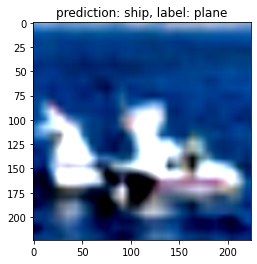

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


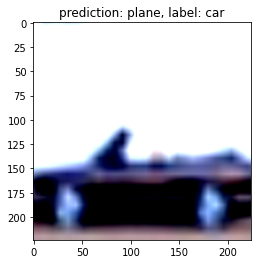

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


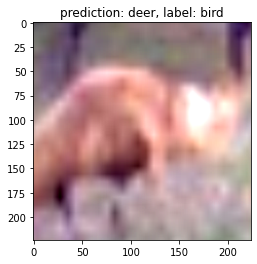

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


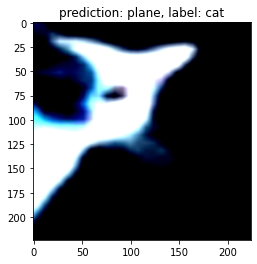

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


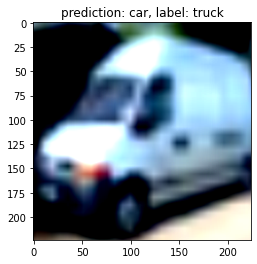

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


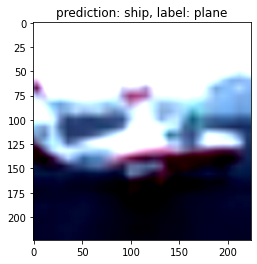

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


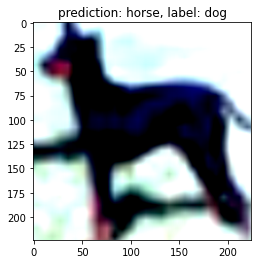

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


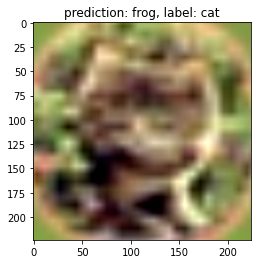

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


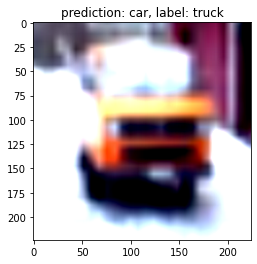

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


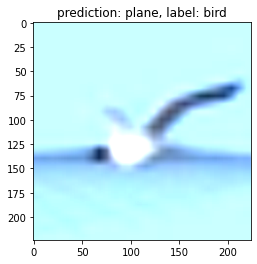

In [ ]:
worst_mistakes = heapq.nlargest(10, wrong_preds,  key=lambda x:x['pred_prob'])

for mistake in worst_mistakes:
  img = mistake['image'] / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(f'prediction: {mistake["pred"]}, label: {mistake["label"]}')
  plt.show()

# Question 3 - י + יא

In [ ]:
class ResBlockDownSamp(nn.Module):

  def __init__(self, in_channels, out_channels=None):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels,
                           out_channels,
                           kernel_size=3,
                           stride=2,
                           padding=1,
                           bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels,
                           out_channels,
                           kernel_size=3,
                           stride=1,
                           padding=1,
                           bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv1_downsample = nn.Conv2d(in_channels,
                                      out_channels,
                                      kernel_size=1,
                                      stride=2,
                                      bias=False)
    self.bn_downsample = nn.BatchNorm2d(out_channels)

  def forward(self, X):
    Y1 = self.conv1(X)
    Y1 = self.bn1(Y1)
    Y1 = self.relu(Y1)
    Y1 = self.conv2(Y1)
    Y1 = self.bn2(Y1)
    Y2 = Y1 + self.conv1_downsample(X)
    Y = self.bn_downsample(Y2)
    return Y

In [ ]:
model_res_new = nn.Sequential(ResBlockDownSamp(in_channels=3, out_channels=128),
                              ResBlockDownSamp(in_channels=128, out_channels=256),
                              ResBlockDownSamp(in_channels=256, out_channels=512),
                              nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                              nn.Flatten(start_dim=1),
                              nn.Linear(in_features=512, out_features=10))
model_res_new = model_res_new.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_res_new.parameters(), lr=0.01, momentum=0.9)
model, wrong_preds = train_model(model=model_res_new, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=2,
                                 check_wrong_preds=False)


Epoch 0/1
----------
train Loss: 1.9164 Acc: 0.2845
val Loss: 1.8163 Acc: 0.3357
Epoch Training complete in 7 minutes

Epoch 1/1
----------
train Loss: 1.7543 Acc: 0.3539
val Loss: 1.6541 Acc: 0.3936
Epoch Training complete in 7 minutes

Total Training complete in 13 minutes

Best val Acc: 0.393600


# הדיוק ירד מ-0.74 במודל הישן של רסנט ל-0.39 במודל החדש שלי, ולכן נעדיף את המודל הישן של רסנט.